<a href="https://colab.research.google.com/github/RishitSingh10/Contrastive-PCA-vs-PCA/blob/main/Contrastive_PCA_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load MNIST Dataset

Number of training samples: 60000
Number of test samples: 10000
Shape of each image: (28, 28)
Shape of each label: ()


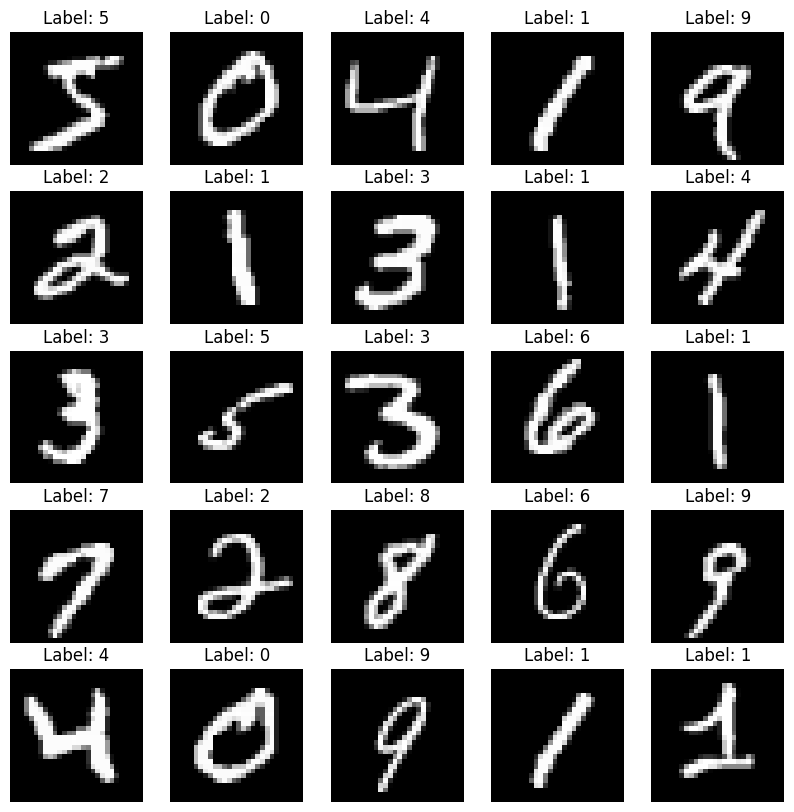

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# The MNIST dataset consists of 28x28 grayscale images.

# Display some information about the loaded dataset
print(f"Number of training samples: {len(train_images)}")
print(f"Number of test samples: {len(test_images)}")

# The shape of the images
print(f"Shape of each image: {train_images[0].shape}")

# The shape of the labels
print(f"Shape of each label: {train_labels[0].shape}")

# Optionally, visualize the first few images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

## PCA on Regular Dataset

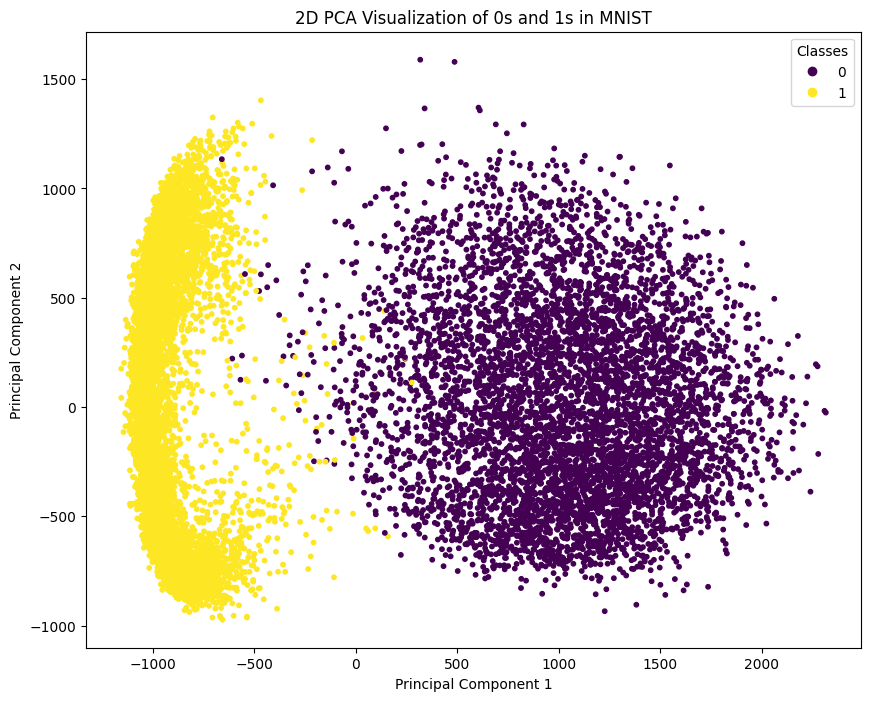

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Filter the dataset to include only 0s and 1s
filter_indices = np.where((train_labels == 0) | (train_labels == 1))
foreground = train_images[filter_indices]
target_labels = train_labels[filter_indices]

# Flatten the filtered images to 1D arrays
fg = foreground.reshape((len(foreground), -1))

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
filtered_images_pca = pca.fit_transform(fg)

# Plot 2D visualization with labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(filtered_images_pca[:, 0], filtered_images_pca[:, 1], c=target_labels, cmap='viridis', s=10)
plt.title('2D PCA Visualization of 0s and 1s in MNIST')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()

## Load Natural Images of Grass

In [ ]:
import cv2

# Load grass images
grass_images = []

for file in images:
    filename = './Grass Images/' + file
    img = cv2.imread(filename)
    img = cv2.resize(img, (100, 100)) # resize to 100x100
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    grass_images.append(gray_img)

len(grass_images)

1500

(202, 302, 3)


(-0.5, 301.5, 201.5, -0.5)

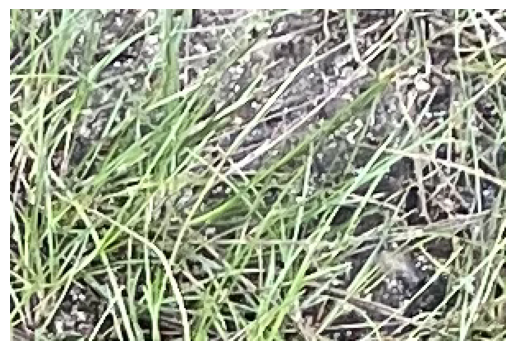

In [ ]:
images = os.listdir('./Grass Images/')

import random
import matplotlib.image as mpimg

random_image = random.choice(images)
image = mpimg.imread('./Grass Images/' + random_image)
print(image.shape)
plt.imshow(image)
plt.axis('off')

## Corrupt MNIST by Superimposing Images of Grass

To create each of the 12,665 corrupted digits, randomly chosen a 28px by 28px region from a grass image to be superimposed on top of the digits

In [ ]:
random.shuffle(grass_images) # shuffle the images
split = int(len(grass_images)/2)

target = grass_images[:split]  # choose the first half of images to be superimposed on target
backgorund = grass_images[split:] # choose the second half of images to be background dataset

corrupted_target = []
non_corrupted_background = []

for digit in foreground:
    target_image = random.choice(target)
    x_pos = random.randint(0, target_image.shape[0] - 28) # Select a random 28x28 patch
    y_pos = random.randint(0, target_image.shape[1] - 28)
    superimposed_patch = target_image[x_pos:x_pos + 28, y_pos:y_pos + 28]
    alpha = 0.72  # Adjust the transparency level
    superimposed_patch = superimposed_patch * alpha
    corrupted_target_image = np.copy(digit)
    # Superimpose the randomly chosen grass patch onto the digit image
    corrupted_target_image = (1 - alpha) * digit + superimposed_patch
    corrupted_target.append(corrupted_target_image)

    background_image = random.choice(backgorund)
    x_pos = random.randint(0, background_image.shape[0] - 28)
    y_pos = random.randint(0, background_image.shape[1] - 28)
    background_patch = background_image[x_pos:x_pos + 28, y_pos:y_pos + 28]
    non_corrupted_background.append(background_patch)

len(corrupted_target), len(non_corrupted_background)

(12665, 12665)

## Some example images

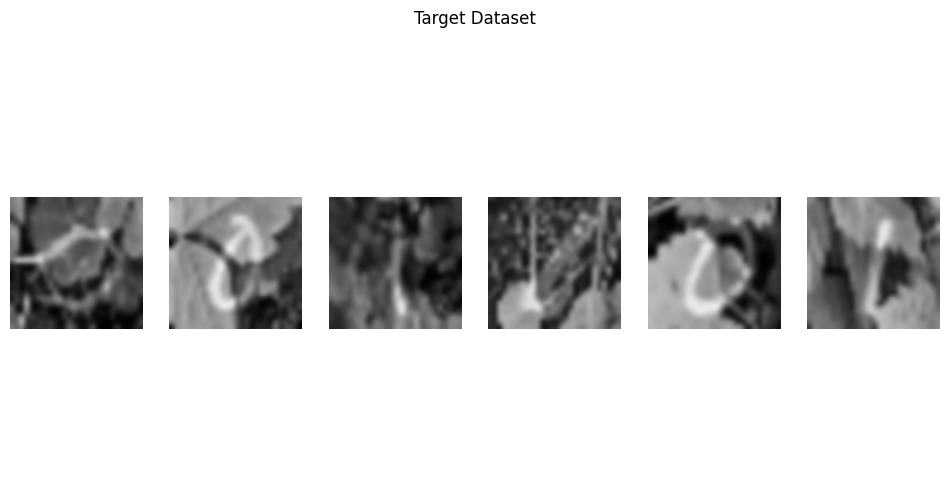

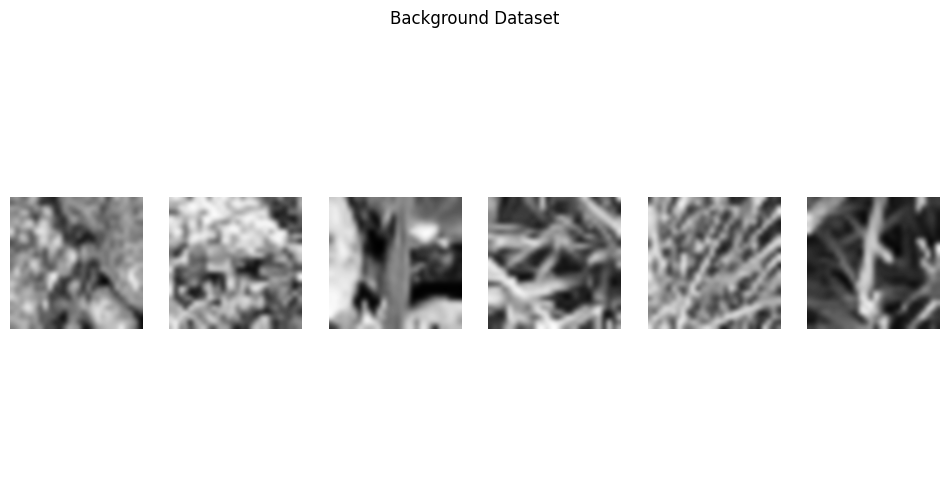

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Target Dataset')
plt.axis('off')

for i in range(6):
    random_corrupted_image = random.choice(corrupted_target)
    plt.subplot(1, 6, i + 1)
    plt.imshow(random_corrupted_image, cmap='gray', interpolation="bicubic")
    plt.axis('off')


plt.figure(figsize=(12, 6))
plt.title('Background Dataset')
plt.axis('off')

for i in range(6):
    random_grass_image = random.choice(non_corrupted_background)
    plt.subplot(1, 6, i + 1)
    plt.imshow(random_grass_image, cmap='gray', interpolation="bicubic")
    plt.axis('off')

## PCA on Corrupted MNIST

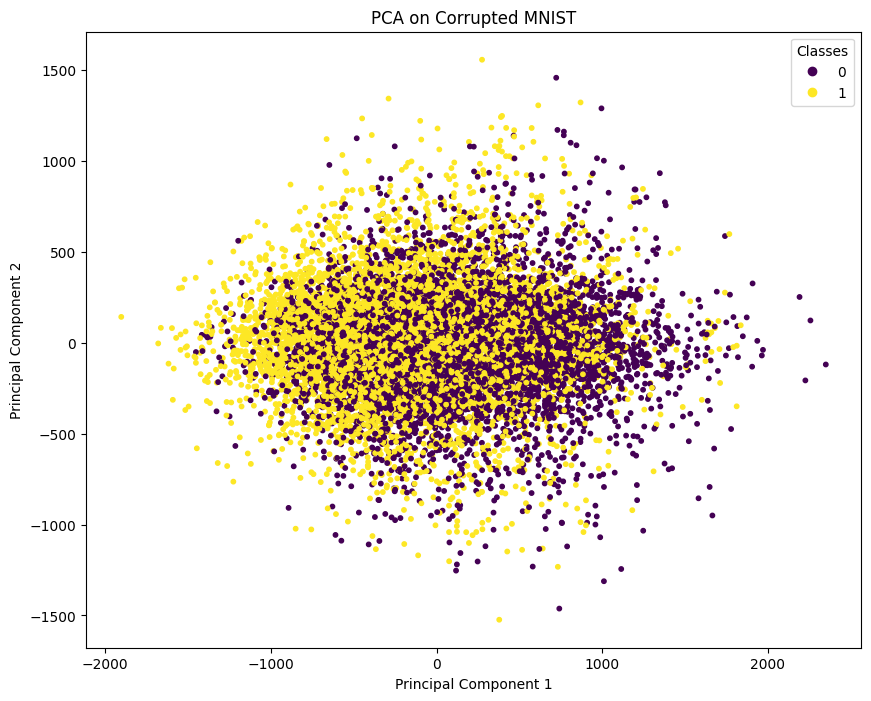

In [ ]:
fg = np.array(corrupted_target).reshape((len(corrupted_target), -1))

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
filtered_images_pca = pca.fit_transform(fg)

# Plot 2D visualization with labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(filtered_images_pca[:, 0], filtered_images_pca[:, 1], c=target_labels, cmap='viridis', s=10)
plt.title('PCA on Corrupted MNIST')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()

## Perform Contrastive PCA

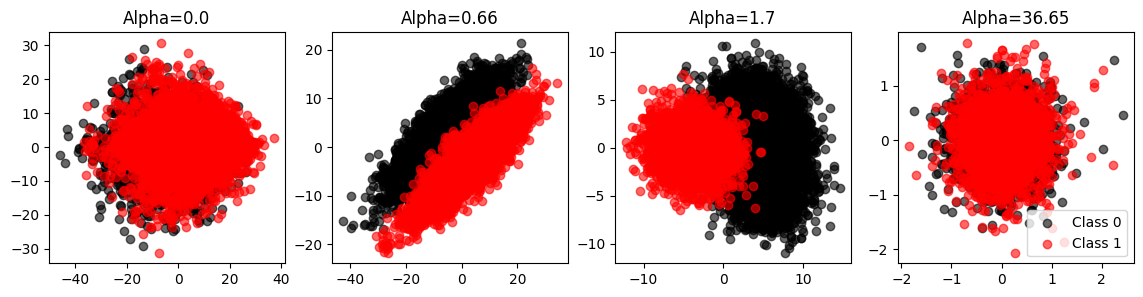

In [ ]:
from contrastive import CPCA

mdl = CPCA()
projected_data = mdl.fit_transform(np.array(corrupted_target).reshape((len(corrupted_target), -1)),
                                   np.array(non_corrupted_background).reshape((len(corrupted_target), -1)),
                                   plot=True, active_labels=target_labels)

## Features Captured by PCA vs. cPCA

Text(0.5, 1.0, 'Contributions of Pixels to cPC1')

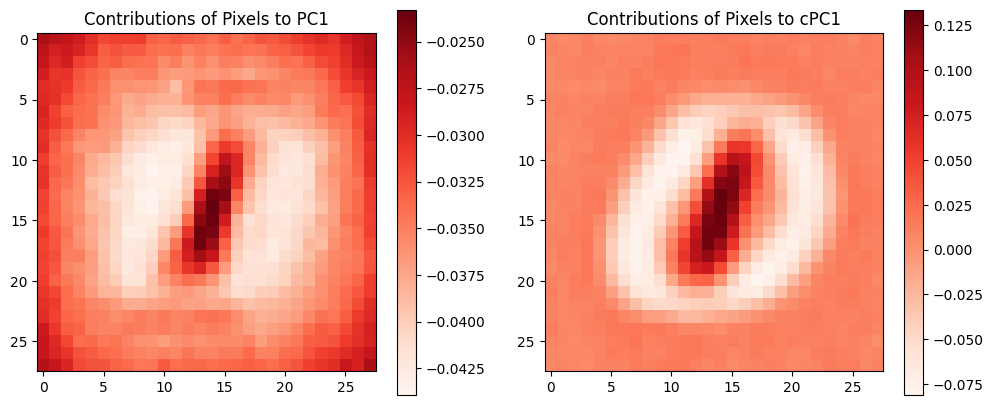

In [ ]:
plt.figure(figsize=[12,5])
w, v = np.linalg.eig(mdl.fg_cov)
idx = np.argmax(w)
plt.subplot(1,2,1)
plt.imshow(v[:,idx].reshape(28,28),cmap='Reds')
plt.colorbar()
plt.title('Contributions of Pixels to PC1')

w, v = np.linalg.eig(mdl.fg_cov - 1.7*mdl.bg_cov) # the value 1.7 is taken from the previous diagram, where alpha=1.7 separates the clusters most clearly
idx = np.argmax(w)
plt.subplot(1,2,2)
plt.imshow(v[:,idx].reshape(28,28),cmap='Reds')
plt.colorbar()
plt.title('Contributions of Pixels to cPC1')